First, we will import the necessary packages and load our data into a pandas dataframe.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

filepath = '/Users/gracemcmonagle/Desktop/School/Fall 2020/EECS 731/Project 6/data/TravelTime_451.csv'
df = pd.read_csv(filepath)

Now, the data has a timestamp column but its currently a string. We transform it to a datetime variable so we can more easily manipulate the times. 

In [17]:
df['timestamp'] = pd.to_datetime(
                          df['timestamp'], 
                          format='%Y-%m-%d %H:%M:%S')

We will now sort the data by timestamp.

In [18]:
df = df.sort_values(by = "timestamp")

For the anomaly detection algorithm cannot handle datetime variables, so we must find another way to measure the time. We set a variable for the first time stamp, and then create a variable for all the other records measuring the number of minutes from the first entry.

In [19]:
first_time = df.iloc[0]['timestamp']

#find difference in time between the first obs and all the rest
df['timestamp'] = df['timestamp'].transform(lambda x : x - first_time)

#find the number of minutes past the first observation of all times
df['timestamp'] = pd.to_numeric(df['timestamp'])/60000000000

We can now take a look at our data on a plot.

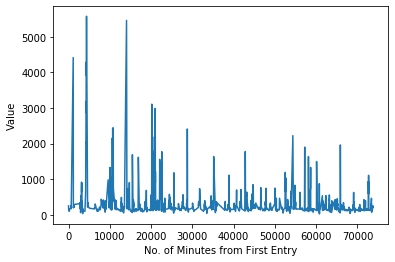

In [20]:
plt.plot(df['timestamp'], df['value'])
plt.xlabel('No. of Minutes from First Entry')
plt.ylabel('Value')
plt.show()

To further understand the values above let's look at a histogram of the values.

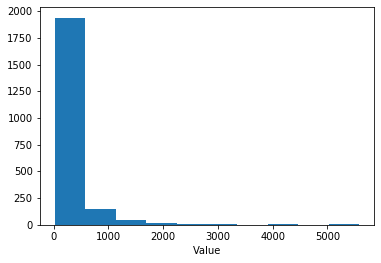

In [21]:
plt.hist(df['value'])
plt.xlabel('Value')
plt.show()

We can see that we have a lot of values below 1000, and higher than that is uncommon. We can now move to our first anomaly detection method.

#### Local Outlier Factor

Our first method for anomaly detection is Local Outlier Factor. We train the model and then graph the result. The red circle around the point is a measurment of the LOF.

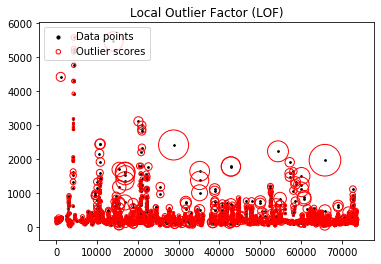

In [22]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
y_pred = clf.fit_predict(df)
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(df['timestamp'], df['value'], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(df['timestamp'], df['value'], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
#plt.xlim((-5, 5))
#plt.ylim((-5, 5))
#plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

As expected, the larger values typically have larger outlier factors. We see fairly small outlier factors towards the bottom of the graph, which is expected. This works pretty well, but let's look at a different method too.

#### Isolation Forest

The next method for anomaly detection that we are going to investigate is Isolation Forest. We first want to train our Isolation Forest model for anomaly detection.

In [23]:
clf = IsolationForest(max_samples=100, random_state=42)
outliers = clf.fit_predict(df)

This model creates a list identifying outliers. So, we want to plot our values and identify the outliers. To do so, we write a small program to color the data points based on whether they're an outlier.

In [24]:
def pltcolor(lst):
    cols = []
    for l in lst:
        if l==1:
            cols.append('black')
        else:
            cols.append('red')
    return cols

Now, we can plot the outliers.

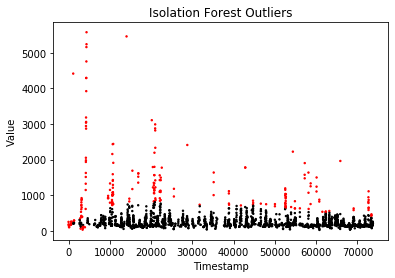

In [25]:
cols = pltcolor(outliers)
plt.scatter(df['timestamp'], df['value'],s =2, c=cols)
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Isolation Forest Outliers')
plt.show()

As in LOF, we see that the outliers are the higher valued values. This is expected given the histogram we looked at at the beginning of this document. We can also tinker with the parameters of these methods to try and get better results, but as the outliers are almost exclusively the high valued values, I'm happy with the parameters we are currently using. 